In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [168]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear,sigmoid
from tensorflow.keras.optimizers import Adam

In [16]:
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip', compression='zip')
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip', compression='zip')

In [18]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [20]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [22]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date

In [23]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

In [26]:
users_scores = submissions_data.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()

In [28]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={
    'timestamp': 'last_timestamp'
})

In [30]:
now = 1526772811
drop_out_treshold = 30 * 24 * 60 * 60 # пороговое значение
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_treshold

users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data = users_data.fillna(0)

In [32]:
users_events_data = events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()
users_data = users_data.merge(users_events_data, how='outer')

In [33]:
users_days = events_data.groupby('user_id').day.nunique()
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_data = users_data.merge(users_days, how='outer')

users_data['passed_course'] = users_data.passed > 175

In [35]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [36]:
users_data.user_id.nunique()

19234

In [40]:
events_data.user_id.nunique()

19234

In [42]:
users_data[users_data.passed_course].day.median()

21.0

<Axes: >

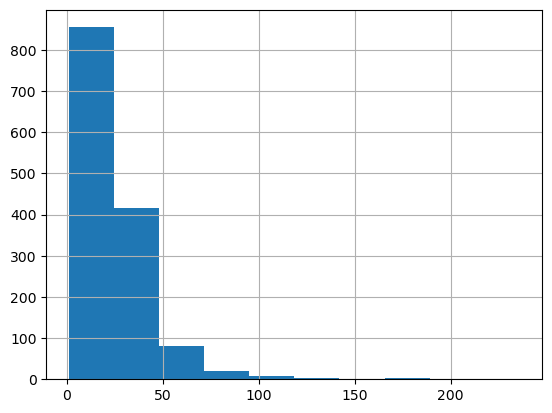

In [44]:
users_data[users_data.passed_course].day.hist()

In [46]:
user_min_time = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1)

In [48]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [50]:
users_data = users_data.merge(user_min_time, how='outer')

In [52]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [54]:
event_data_train = pd.DataFrame()

In [56]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [57]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [58]:
learning_time_treshold = 3 * 24 * 60 * 60
learning_time_treshold

259200

In [59]:
user_learning_time_treshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_treshold).map(str)

In [60]:
user_learning_time_treshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

In [66]:
user_min_time['user_learning_time_treshold'] = user_learning_time_treshold

In [68]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')

In [69]:
events_data.shape

(3480703, 8)

In [70]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,31981,1472827464,viewed,1,2016-09-02 14:44:24,2016-09-02,1_1472827464,1_1473086664
1,31981,1472827464,discovered,1,2016-09-02 14:44:24,2016-09-02,1_1472827464,1_1473086664
2,32815,1514383364,discovered,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514642564
3,32815,1514383364,viewed,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514642564
4,32815,1514383364,passed,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514642564


In [71]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_treshold]

In [74]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,31981,1472827464,viewed,1,2016-09-02 14:44:24,2016-09-02,1_1472827464,1_1473086664
1,31981,1472827464,discovered,1,2016-09-02 14:44:24,2016-09-02,1_1472827464,1_1473086664
2,32815,1514383364,discovered,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514642564
3,32815,1514383364,viewed,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514642564
4,32815,1514383364,passed,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514642564


In [78]:
events_data_train.shape

(1014985, 8)

In [80]:
events_data_train.groupby('user_id').day.nunique().max()

4

In [82]:
submissions_data['user_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.user_time <= submissions_data.user_learning_time_treshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

In [84]:
X = submissions_data_train.groupby('user_id').day.nunique(). \
    to_frame().reset_index().rename(columns=({
        'day': 'days'
}))

In [86]:
X.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


In [88]:
steps_tried = submissions_data_train.groupby('user_id').step_id \
    .nunique().to_frame().reset_index().rename(columns={
        'step_id': 'steps_tried'
})

In [90]:
steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23


In [92]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [94]:
X.shape

(8913, 3)

In [96]:
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [98]:
submissions_data_train.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index().head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,4,4
2,8,9,21
3,14,0,1
4,16,23,27


In [100]:
X = X.merge(submissions_data_train.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index())

In [102]:
X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27


In [104]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [106]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [108]:
X = X.merge(events_data_train.pivot_table(index='user_id',
                        columns='action',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [110]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,1,NaN,NaN,NaN,NaN,NaN,1
1,2,1.0,2.0,2.0,0.0,1.0,9
2,3,1.0,4.0,4.0,4.0,0.5,20
3,5,NaN,NaN,NaN,NaN,NaN,1
4,7,NaN,NaN,NaN,NaN,NaN,1


In [112]:
X.shape

(19234, 7)

In [114]:
X = X.fillna(0)

In [116]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')

In [118]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,1,0.0,0.0,0.0,0.0,0.0,1,False,True
1,2,1.0,2.0,2.0,0.0,1.0,9,False,True
2,3,1.0,4.0,4.0,4.0,0.5,20,False,True
3,5,0.0,0.0,0.0,0.0,0.0,1,False,True
4,7,0.0,0.0,0.0,0.0,0.0,1,False,True


In [120]:
X[(X.is_gone_user == False) & (X.passed_course == False)].head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
7,11,0.0,0.0,0.0,0.0,0.000000,1,False,False
14,24,0.0,0.0,0.0,0.0,0.000000,2,False,False
15,25,1.0,2.0,1.0,4.0,0.200000,40,False,False
20,32,1.0,3.0,3.0,0.0,1.000000,14,False,False
41,57,3.0,13.0,13.0,28.0,0.317073,70,False,False


In [122]:
X[~((X.is_gone_user == False) & (X.passed_course == False))].head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,1,0.0,0.0,0.0,0.0,0.0,1,False,True
1,2,1.0,2.0,2.0,0.0,1.0,9,False,True
2,3,1.0,4.0,4.0,4.0,0.5,20,False,True
3,5,0.0,0.0,0.0,0.0,0.0,1,False,True
4,7,0.0,0.0,0.0,0.0,0.0,1,False,True


In [124]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [126]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,1,0.0,0.0,0.0,0.0,0.0,1,False,True
1,2,1.0,2.0,2.0,0.0,1.0,9,False,True
2,3,1.0,4.0,4.0,4.0,0.5,20,False,True
3,5,0.0,0.0,0.0,0.0,0.0,1,False,True
4,7,0.0,0.0,0.0,0.0,0.0,1,False,True


In [128]:
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            16590
True           False             136
               True             1254
Name: user_id, dtype: int64

In [130]:
y = X.passed_course.map(int)

In [132]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)

In [134]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)

In [136]:
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
1,0.0,0.0,0.0,0.0,0.0,1
2,1.0,2.0,2.0,0.0,1.0,9
3,1.0,4.0,4.0,4.0,0.5,20
5,0.0,0.0,0.0,0.0,0.0,1
7,0.0,0.0,0.0,0.0,0.0,1


In [138]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: passed_course, dtype: int64

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [142]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [154]:
model = Sequential([
    Dense(32, input_dim=X.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

C:\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [156]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [158]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8716 - loss: 0.3545 - val_accuracy: 0.9232 - val_loss: 0.2216
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9234 - loss: 0.2070 - val_accuracy: 0.9246 - val_loss: 0.2153
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9228 - loss: 0.2116 - val_accuracy: 0.9269 - val_loss: 0.2133
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9217 - loss: 0.2103 - val_accuracy: 0.9252 - val_loss: 0.2140
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9229 - loss: 0.2130 - val_accuracy: 0.9263 - val_loss: 0.2122
Epoch 6/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9220 - loss: 0.2150 - val_accuracy: 0.9269 - val_loss: 0.2136
Epoch 7/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9222 - loss: 0.2128 - val_accuracy: 0.9260 - val_loss: 0.2140
Epoch 8/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9273 - loss: 0.2003 - val_accuracy: 0.

In [159]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

In [3]:
test_loss,test_acc

NameError: name 'test_loss' is not defined

In [161]:
# alternative solution using Random Forest and GridSearchCV with cross-validation
# rf = RandomForestClassifier(random_state=42)

# parametrs = {
#     'n_estimators': range(10, 51, 10),
#     'max_depth': range(1, 13, 2),
#     'min_samples_leaf': range(1, 8),
#     'min_samples_split': range(2, 10, 2)
# }

# grid_search = GridSearchCV(rf, param_grid=parametrs, cv=5, n_jobs=-1, verbose=1)
# grid_search.fit(X_train, y_train)

# best_rf = grid_search.best_estimator_

# y_pred = best_rf.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred) -> output 0.9271412680756396